In [1]:
%load_ext autoreload
%autoreload 2
from experiment.proj1_helpers import *
from implementations import * 
from experiment.cleaning import *
from experiment.cross_validation import *
from experiment.simulation import *
from experiment.visualisation import *

In [2]:
data_path = "data/train.csv"

In [3]:
y, x, ids = load_csv_data(data_path, sub_sample=False)

In this notebook, we will show the optimisation procedure we applied to our ridge regression model. 

We will start by establishing a baseline result by running the algorithm directly on the raw dataset. 

Beginning training
Beginning cross-validation


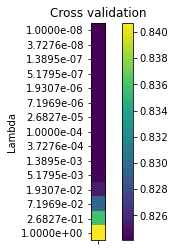

Accuracy of ridge_regression on the local test set : 0.7440
F1-score of ridge_regression on the local test set : 0.5704


In [4]:
acc_local_test, f1_local_test, w_best, _, best_lambda = run_experiment(y, x, 'ridge_regression', 1, 0.8, [], degree_exp=False, expansion=False, standard=False)

In [5]:
best_lambda

1e-08

## Exploratory Data Analysis
We will then do some exploratory data analysis to find outliers or odd things in the data. 

All features are numeric. The number of jets is discrete.

#### Distribution of the features
Let's look at the distribution of some of the features.

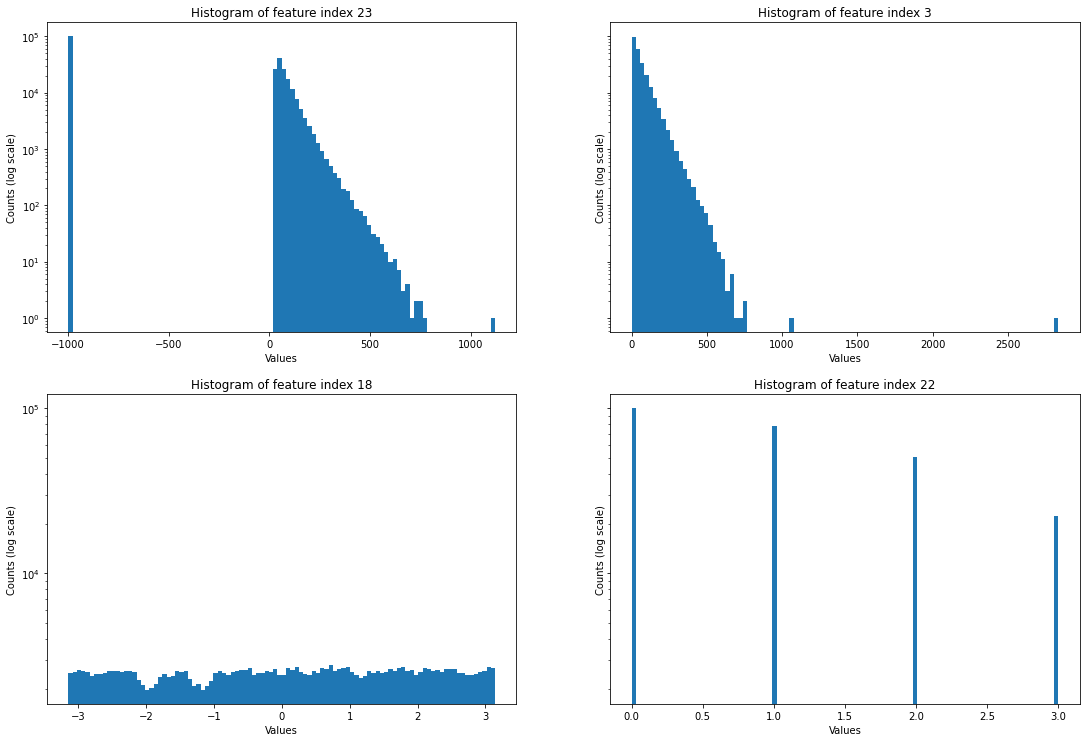

In [6]:
quad_histograms(x,23,3,18,22)

We can see that some features clearly have a lot default values (-999), some seem to have extreme outliers (e.g. feature 3). We can also check that feature index 22 only has non negative integer values as this feature correspond to the jet number.

### Data cleaning

We start by checking numerically that the jet numbers (22th feature) are non-negative integers. We also check that there are no nan value in the dataset.

In [7]:
print(f'Number of negative values : {np.sum(x[:, 22] < 0)}')

Number of negative values : 0


In [8]:
# Check that no value in the table is a nan value
print(f'Number of nan values in dataset : {np.sum(x==np.nan)}')

Number of nan values in dataset : 0


We can see that we have 250'000 data points with 30 features each.

In [9]:
x.shape

(250000, 30)

In [10]:
np.sum(x == -999, axis=0)

array([ 38114,      0,      0,      0, 177457, 177457, 177457,      0,
            0,      0,      0,      0, 177457,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,  99913,
        99913,  99913, 177457, 177457, 177457,      0])

We can see that some of the features have a very high number of undefined values (-999). We could replace this undefined values by e.g. 0 or the median of the remaining values but this would result in columns having its majority of entries (e.g. 177'000 / 250'000 $\approx$ 0.7) at the same value. This would imply that there is not a lot of variance in the feature and therefore this does not give much information about the label we want to predict. So we decided to drop the features where more than half of the rows are at -999.

In [11]:
# We remove the features where more than half of the rows are -999
x_cleaned, col_removed_training = remove_col_default_values(x)

In [12]:
col_removed_training

[4, 5, 6, 12, 26, 27, 28]

We can see that with our approach we dropped 7 columns.

We also looked if some rows were having more than half of its features set to a default value (i.e. -999). In this case, there were no such rows.

In [13]:
check_nb_rows_default_features(x_cleaned)

Number of rows : 0


For the default values reamining in the dataset, we choose to replace them with the median value of the corresponding feature.  

In [14]:
x_cleaned, default_values_training = replace_by_default_value(x_cleaned)

Some features represents angles, which are supposed to be in the range $[\pi; -\pi[$ according to the documentation of the dataset (https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf). Let's check this is the case.

In [15]:
cols_angle = [11, 14, 16, 21]
x_cleaned = check_all_azimuth_angles(x_cleaned, cols_angle)

Number of values outside [-pi;pi[ (col 11): 9
Number of values outside [-pi;pi[ (col 14): 11
Number of values outside [-pi;pi[ (col 16): 9
Number of values outside [-pi;pi[ (col 21): 3


We can see that some of the features have rows with azimuth outside the range. For these features indexes we deciced to put the non-valid values back in the $[-\pi; \pi[$ interval by taking the modulo $2 \pi$ and subtracting $\pi$.

### Removing outliers

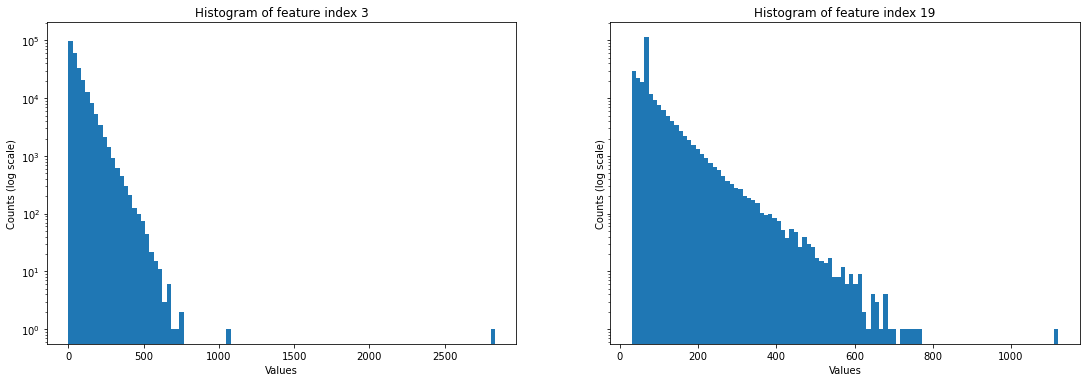

In [16]:
double_histograms(x_cleaned, 3,19)

We can observe that in some features there still seems to be some outliers (e.g. see the histogram above for feature index 3).

We will deal with them using a method based on the [Inter Quartile Range (IQR)](https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/). 

In [17]:
x_cleaned, above_lim_training, below_lim_training = clip_IQR(x_cleaned)

We now have a cleaned version of the dataset. Let's take a look at the performance of the ridge regression on our cleaned dataset. 

Note that from now, we also apply a $z$-normalisation to each feature of the dataset 

End of standardisation
Beginning training
Beginning cross-validation


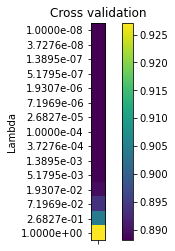

Accuracy of ridge_regression on the local test set : 0.7091
F1-score of ridge_regression on the local test set : 0.6564


In [18]:
acc_local_test, f1_local_test, w_best, _, best_lambda = run_experiment(y, x_cleaned, 'ridge_regression', 1, 0.8, [], degree_exp=False, expansion=False, standard=True)

In [19]:
best_lambda

0.0001

We can note two different things from the previous run of the ridge regression model. 
1. The accuracy on the local test set decreases by a ~$4\%$. 
2. We can see that the model is underfitting the data as $\lambda$ growths which is exactly what we expect when we use regularisation. 

Let's now apply the feature expansion and see what are the results. For now, we only add a bias term, the sine and cosine of the angle features and the interaction between all the features. 

End of standardisation
End of processing + expansion
Beginning training
Beginning cross-validation


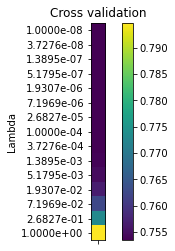

Accuracy of ridge_regression on the local test set : 0.8081
F1-score of ridge_regression on the local test set : 0.7058


In [20]:
acc_local_test, f1_local_test, w_best, best_degree, best_lambda = run_experiment(y, x_cleaned, 'ridge_regression', 1, 0.8, cols_angle, degree_exp=False, expansion=True, standard=True)

In [21]:
best_lambda

7.196856730011514e-06

We can see that the performances of the ridge regression are considerably increased after we apply the feature expansion explained above (and in the report)

Recall that the our data cleaning decreases the accuracy on the raw dataset by ~$4\%$. We can now ask ourselves if the preprocessing and the data cleaning is really efficient when we combined it with the feature expansion (note that we need to adapt the angle columns as no columns are removed). 

End of standardisation
End of processing + expansion
Beginning training
Beginning cross-validation


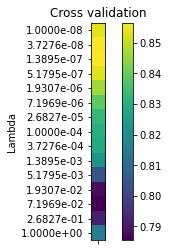

Accuracy of ridge_regression on the local test set : 0.7833
F1-score of ridge_regression on the local test set : 0.6569


In [22]:
acc_local_test, f1_local_test, w_best, best_degree, best_lambda = run_experiment(y, x, 'ridge_regression', 1, 0.8, [14, 17, 19, 24, 28], degree_exp=False, expansion=True, standard=True)

In [23]:
best_lambda

0.07196856730011514

From the previous result, we can see that our feature expansion combined with the data cleaning is more performant than the feature expansion on the raw dataset only. 

The last improvement, we will add to our model is the power expansion of the original feature (on the cleaned dataset). The best degree is determined using cross-validation. 

End of standardisation
End of processing + expansion
Beginning training
Beginning cross-validation


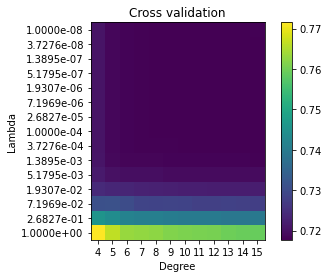

Accuracy of ridge_regression on the local test set : 0.8263
F1-score of ridge_regression on the local test set : 0.7368


In [24]:
acc_local_test, f1_local_test, w_best, best_degree, best_lambda = run_experiment(y, x_cleaned, 'ridge_regression', 1, 0.8, cols_angle, max_degree=15, degree_exp=True, expansion=True, standard=True)

In [25]:
best_degree, best_lambda

(10, 7.196856730011514e-06)

We can see that the degree for which the loss is minimised on the validation sets is the degree $deg=10$ with which we reach $82.63\%$ of accuracy.

With these two parameters, we reach our highest score in aicrowd.com with $82.8\%$ accuracy and a F1-score of $0.738$.

In [26]:
from run import *
main()

==> Loading and preprocessing training data...

Number of values outside [-pi;pi[ (col 11): 9
Number of values outside [-pi;pi[ (col 14): 11
Number of values outside [-pi;pi[ (col 16): 9
Number of values outside [-pi;pi[ (col 21): 3

==> Training model...

==> Loading and preprocessing test data...

Number of values outside [-pi;pi[ (col 11): 19
Number of values outside [-pi;pi[ (col 14): 17
Number of values outside [-pi;pi[ (col 16): 22
Number of values outside [-pi;pi[ (col 21): 9
(704,)

==> Predicting labels for the test set...

==> Creating submission file...

==> Submission files saved.
